In [1]:
import os
import socket
import os
def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

os.environ["MASTER_PORT"] = str(find_free_port())
print(f"[INFO] Using MASTER_PORT={os.environ['MASTER_PORT']}")
from os.path import join, splitext
import json
from tqdm.notebook import tqdm
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from torchmetrics.classification import MultilabelAccuracy
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights, resnet152,ResNet152_Weights
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from utils import CheXpertDataModule, CheXpertCNN, ensemble_pred

[INFO] Using MASTER_PORT=40863


/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/storage/ice1/1/7/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[INFO] Using MASTER_PORT=56887


In [2]:
data_folder = '../../../../../../../storage/ice1/shared/bmed6780/mip_group_2/CheXpert Plus'
num_classes = 14

In [3]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices='auto', # or specify a list like devices=[0,1]
    precision="16-mixed",
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


#### densenet121

In [4]:
# model
densenet121_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
densenet121_model.classifier = nn.Linear(densenet121_model.classifier.in_features, num_classes)
# load a checkpoint
densenet121_model = CheXpertCNN.load_from_checkpoint(
    "checkpoints/lr_5e-5_batch_size_16_best-epoch=2-val_loss=0.17.ckpt",
    num_classes=14,  # same as used during training
    model=densenet121_model
)
# set up a dataset
densenet121_data = CheXpertDataModule(data_dir=data_folder, transform=DenseNet121_Weights.DEFAULT.transforms())
densenet121_data.setup('test')

In [5]:
trainer.test(densenet121_model, densenet121_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9432234764099121
        test_loss           0.17673853039741516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17673853039741516, 'test_acc': 0.9432234764099121}]

#### resnet152

In [6]:
# model
resnet152_model = resnet152(weights=ResNet152_Weights.DEFAULT)
resnet152_model.fc = nn.Linear(resnet152_model.fc.in_features, num_classes)
# load a checkpoint
resnet152_model = CheXpertCNN.load_from_checkpoint(
    "checkpoints/resnet_best-epoch=2-val_loss=0.17.ckpt",
    num_classes=14,  # same as used during training
    model=resnet152_model
)
# set up a dataset
resnet152_data = CheXpertDataModule(data_dir=data_folder, transform=ResNet152_Weights.DEFAULT.transforms())
resnet152_data.setup('test')

In [7]:
trainer.test(resnet152_model, resnet152_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9447497725486755
        test_loss           0.1670302152633667
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1670302152633667, 'test_acc': 0.9447497725486755}]

#### xception

In [8]:
# model
xception_model = timm.create_model('xception', pretrained=True, num_classes=num_classes)
# load a checkpoint
xception_model = CheXpertCNN.load_from_checkpoint(
    "checkpoints/xception_best-epoch=1-val_loss=0.17.ckpt",
    num_classes=14,  # same as used during training
    model=xception_model
)

/home/hice1/zzhai37/.conda/envs/nsp/lib/python3.11/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [9]:
from timm.data import resolve_data_config, create_transform

# get a dict of data settings from the model’s default_cfg
config = resolve_data_config(model=xception_model)
test_transform = create_transform(
    input_size=config['input_size'],
    is_training=False,        # or False for validation
    color_jitter=config.get('color_jitter', None),
    auto_augment=config.get('auto_augment', None),
    interpolation=config['interpolation'],
    mean=config['mean'],
    std=config['std'],
)

In [10]:
# set up a dataset
xception_data = CheXpertDataModule(data_dir=data_folder, transform=test_transform)
xception_data.setup('test')

In [11]:
trainer.test(xception_model, xception_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9017093181610107
        test_loss           0.9603592157363892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9603592157363892, 'test_acc': 0.9017093181610107}]

#### ensemble 

In [12]:
models = [densenet121_model, resnet152_model, xception_model]
datamodules = [densenet121_data, resnet152_data, xception_data]

acc = ensemble_pred(models, datamodules, trainer)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

Ensemble test acc: 0.9405


/tmp/ipykernel_3609262/979098345.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=df,


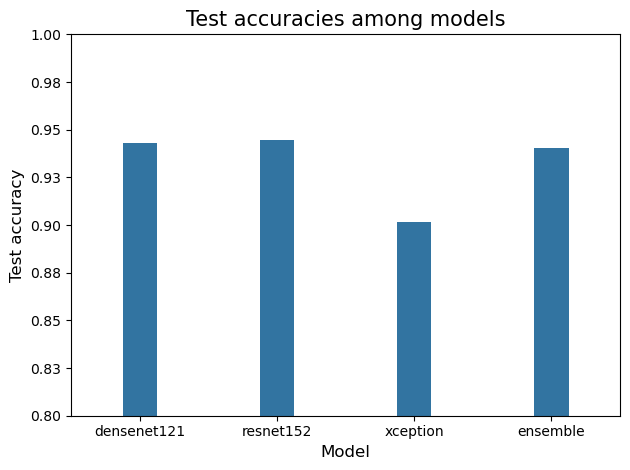

In [36]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Create some example data ────────────────────────────────────────────────
rng = np.random.default_rng(seed=42)
df = pd.DataFrame({
    'Model': np.array(['densenet121','resnet152','xception', 'ensemble']),
    'Test accuracy': np.array([
        0.9432234764099121,
        0.9447497725486755,
        0.9017093181610107,
        0.9405
    ])
})

# # ─── Plot with standard‐deviation error bars ─────────────────────────────────
# For seaborn < 0.12:
ax = sns.barplot(data=df,
            x='Model',
            y='Test accuracy',
            ci='sd',
            width=0.25)               # use 'sd' instead of default 95% CI

# If you have seaborn ≥ 0.12 you can also write:
# sns.barplot(data=df, x='category', y='value',
#             estimator=np.mean,
#             errorbar=('sd', 1))   # ('sd', 1) means ±1 standard deviation
ax.set_ylim(0.8, 1)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
ticks = np.arange(0.8, 1.01, 0.025)
labels = [f"{t:.2f}" for t in ticks]
plt.yticks(np.arange(0.8, 1.01, 0.025), labels)
plt.title('Test accuracies among models', fontsize=15)
plt.tight_layout()
plt.savefig('test_accu.png', dpi=300)
plt.show()

In [38]:
np.average((1, 2, 3))

np.float64(2.0)

#### cam

In [13]:
# set up once
class_idx     = 0
targets       = [ClassifierOutputTarget(class_idx)]

#### densenet121

  0%|          | 0/15 [00:00<?, ?it/s]

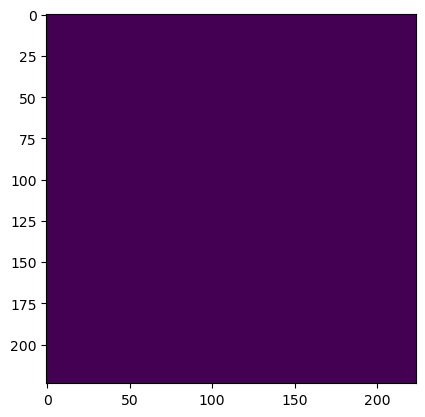

In [14]:
target_layers = [densenet121_model.model.features[-1]] # model specific
for imgs, _ in tqdm(densenet121_data.test_dataloader()): # data module specific
    # model specific
    with GradCAM(model=densenet121_model.model, target_layers=target_layers) as cam:
        cam_batch = cam(input_tensor=imgs, targets=targets)
        plt.imshow(cam_batch[0])

#### resnet152

In [ ]:
target_layers = [resnet152_model.model.layer4[-1]] # model specific
for imgs, _ in tqdm(resnet152_data.test_dataloader()): # data module specific
    # model specific
    with GradCAM(model=resnet152_model.model, target_layers=target_layers) as cam:
        cam(input_tensor=imgs, targets=targets)